In [1]:
import pandas as pd
import pypsa
from scripts.__helpers import replace_su, average_every_nhours
import numpy as np
import os
import math

In [2]:
from pypsa.descriptors import get_switchable_as_dense as as_dense

In [3]:
def solve_rolling_horizon(m, o, time_aggregation, horizon):
    
    horizon = int(storage_preopt_aggregation.split("h")[0])
    
    o.storage_units.cyclic_state_of_charge=False
    o.stores.e_cyclic=False

    o.stores_t.e_min_pu = (
        (m.stores_t.e/m.stores.e_nom)
        .shift(1)
        .resample(time_aggregation).asfreq()
        .shift(-1)
        .fillna(0)
    ).clip(upper=.999).reindex(o.snapshots).fillna(0)

    o.stores.e_initial = m.stores_t.e.iloc[-1]
    
    for i in range(len(o.snapshots)//horizon):

        start= i* horizon
        end = min((i+1)*horizon, len(o.snapshots))
        
        print("optimizing time period between " + str(o.snapshots[start]) + " and " + str(o.snapshots[end-1]))
        
        snapshots = o.snapshots[start:end]
              
        status, condition = o.optimize(solver_name=solver_name,
                   snapshots = snapshots,
                   assign_all_duals=True,
                   extra_functionality=extra_functionality,
                   linearized_unit_commitment = True,
                   **solver_options
              )
        
        if "infeasible" in condition:
            raise RuntimeError("Solving status 'infeasible'")

        
        
        o.stores.e_initial = o.stores_t.e.loc[snapshots].iloc[-1]

In [4]:
def get_ordc_integral(excess_reserve, mean, std):
    
    return (
        -0.5*excess_reserve 
        + 0.5*(
            (excess_reserve - mean)*math.erf((excess_reserve-mean)/(std*math.sqrt(2)))
            + math.sqrt(2)*std*math.exp(-(excess_reserve-mean)**2/(2*std**2))/math.sqrt(math.pi)
        )
    )

In [5]:
def determine_cutoff(zone):
    cost_function = pd.Series([get_ordc_integral(i, **ordc_parameters.loc[zone]) for i in range(0,40000,10)], 
                              index = range(0,40000,10))

    return cost_function.diff()[cost_function.diff()/pd.Series(cost_function.index).diff().median()<=-0.00001].index[-1]

In [6]:
def get_break_points(n_ints, zone, cut_off):
    
    break_points = pd.DataFrame(index=range(n_ints+1))
    break_points["cap_break_points"] = list(np.arange(0, cut_off[zone], cut_off[zone]/n_ints)) + [2*cut_off[zone]]
    break_points["welfare_break_points"] = [get_ordc_integral(i, **ordc_parameters.loc[zone]) for i in break_points.cap_break_points]
    break_points.set_index(pd.Series(zone,index=break_points.index), inplace=True,append=True)
    break_points = break_points.reorder_levels([1,0])
    
    return break_points

In [7]:
def get_linear_function(p, q):
    m = (p[1] - q[1])/(p[0] - q[0])
    b = (p[0]*q[1] - p[1]*q[0])/(p[0] - q[0])
    return m, b

In [8]:
def get_line_parameters(ordc_parameters, n_ints):
    cut_off = pd.Series(index=ordc_parameters.index, data=[determine_cutoff(i) for i in ordc_parameters.index])

    break_points = pd.DataFrame()
    for zone in ordc_parameters.index:

        break_points = pd.concat([break_points, get_break_points(n_ints, zone, cut_off)])

    line_parameters = pd.DataFrame()
    for zone in ordc_parameters.index:
        j = 0    
        for i in break_points.loc[zone].index[:-1]:
            m, b = get_linear_function(break_points.loc[zone, i], break_points.loc[zone, i+1])
            line_parameters = pd.concat([line_parameters, pd.Series(index=["a", "b"], data=[m, b], name=(zone, j))],axis=1)
            j+=1

    return line_parameters.T.set_index((i for i in line_parameters.columns))

In [9]:
def balancing_market(n, snapshots):
    
    m = n.model

    reserve_gens = n.generators.loc[n.generators.bus.map(n.buses.carrier) == "electricity"]
    reserve_gens = reserve_gens.query("carrier in @reserve_participation_generators")

    coord_reserve_gens = reserve_gens.index
    coord_reserve_gens.name = "Generator-fix"

    gen_r = m.add_variables(lower=0, name="Generator-r", coords = [snapshots, coord_reserve_gens])

    lhs = m.constraints["Generator-fix-p-upper"].lhs
    rhs = m.constraints["Generator-fix-p-upper"].rhs
    m.remove_constraints("Generator-fix-p-upper")
    m.add_constraints(lhs + gen_r <= rhs, name= "Generator-fix-p-upper")

    committable = reserve_gens.query("committable == True").copy()

    committable_grouper = pd.Series(committable.index, committable.index)
    committable_grouper.name="Generator-com"

    lhs = m.constraints["Generator-com-p-upper"].lhs
    rhs = m.constraints["Generator-com-p-upper"].rhs

    lhs += gen_r.loc[:, committable.index].groupby(committable_grouper).sum()
    m.remove_constraints("Generator-com-p-upper")
    m.add_constraints( lhs <= rhs, name="Generator-com-p-upper")

    gen_status = m["Generator-status"]

    reserve_gen_status = gen_status.loc[:, committable.index]

    m.add_constraints(
        gen_r.loc[:, committable.index].groupby(committable_grouper).sum()
        <= (
            reserve_gen_status*
            (
                committable.groupby(committable_grouper).ramp_limit_up.sum()
                .multiply(delivery_time_reserves)
                .multiply(committable.groupby(committable_grouper).p_nom.sum())     
            )
        ),
        name = "Generator-com-ramp_upper"
    )
    


    res_shedding = m.add_variables(
        lower=0, 
        name="Bus-reserve_shedding", 
        coords=[snapshots, reserve_requirements.index]
    )

    storage = n.links.loc[n.links.type == "discharging"]

    storage_link_r = m.add_variables(lower = 0, name="Link-r", coords = m["Link-p"].loc[:, storage.index].coords)

    link_p = m["Link-p"]

    m.add_constraints(
        link_p.loc[:, storage.index] + storage_link_r <= n.links.p_nom.to_xarray(),
        name = "Link-capacity_upper"
    );

    store_e = m["Store-e"]

    store_link_map = n.stores.set_index("bus",append=True).reset_index("Store").reindex(storage.bus0)["Store"]
    store_link_map.index = storage.index
    store_link_map.index.name = "Link"
    store_link_map.name="Store"

    m.add_constraints(
        storage_link_r.groupby(store_link_map.to_xarray()).sum() <= store_e,
        name="Link-reserve_reservoir_constraint"
    )

    gen_grouper = reserve_gens.bus
    gen_grouper.name = "Bus"

    storage_grouper = storage.bus1
    storage_grouper.name = "Bus"

    if ORDC == True:

        excess_r = m.add_variables(
            lower = 0,
            upper= 40,
            name = "Bus-excess_r",
            coords = [snapshots, reserve_requirements.index]
        )

        m.add_constraints(
            gen_r.groupby(gen_grouper.to_xarray()).sum() 
            + storage_link_r.groupby(storage_grouper.to_xarray()).sum()
            + res_shedding
            - excess_r
            >= 0,
            name="Bus-reserve_balance"
        )

        
        a = linear_ordc_approximation["a"]
        b = linear_ordc_approximation["b"]

        a.index.names = ["Bus", "break_point"]
        b.index.names = ["Bus", "break_point"]


        ordc_cost_term = m.add_variables(coords=excess_r.coords, name="Bus-ORDC_cost")
        
        m.add_constraints(
            ordc_cost_term >= (a.to_xarray()*excess_r + b.to_xarray())*VOLL,
            name="Bus-ORDC"
        )

        obj = m.objective
        m.add_objective(obj + res_shedding.sum()*reserve_scarcity_price + ordc_cost_term.sum(), overwrite=True) 

    else:

        m.add_constraints(
            gen_r.groupby(gen_grouper.to_xarray()).sum() 
            + storage_link_r.groupby(storage_grouper.to_xarray()).sum()
            + res_shedding
            >= reserve_requirements.reindex(n.buses.query("carrier == 'electricity'").index).dropna().to_xarray(),
            name="Bus-reserve_balance"
        )

        obj = m.objective

        m.add_objective(obj + res_shedding.sum()*reserve_scarcity_price, overwrite=True)

In [10]:
def flow_based_market_coupling(n, snapshots)   :
    
    m = n.model
    
    ac_core = n.links.query("(carrier == 'AC') & (bus0 in @ptdf_core.columns) & (bus1 in @ptdf_core.columns) ")

    ac_bus0 = ac_core.bus0.copy()
    ac_bus0.name = "bus"

    ac_bus1 = ac_core.bus1.copy()
    ac_bus1.name = "bus"

    net_position_core = m.add_variables(coords=[snapshots, ptdf_core.columns], name="Bus-net_position")

    m.add_constraints(
        net_position_core  == (
            m["Link-p"].loc[:, ac_core.index].groupby(ac_bus0.to_xarray()).sum()
            - m["Link-p"].loc[:, ac_core.index].groupby(ac_bus1.to_xarray()).sum()
        ),
        name="Bus-net_position_zones"
    );

    net_position_alegro = m.add_variables(
        coords=[
            snapshots, 
            pd.Index(["Allegro"], name="Link")
        ],
        name="Net_position_alegro"
    )

    m.add_constraints(
        net_position_alegro == m["Link-p"].loc[:, "BE00-DE00-DC"] - m["Link-p"].loc[:, "DE00-BE00-DC"],
        name="Bus-alegro"
    );

    ahc_flows = n.links[
        (
            (n.links.bus0.isin(ptdf_core.columns) & ~n.links.bus1.isin(ptdf_core.columns))
            | (n.links.bus1.isin(ptdf_core.columns) & ~n.links.bus0.isin(ptdf_core.columns))
        ) & n.links.carrier.isin(['AC', 'DC'])

    ]

    ahc0 = pd.Series(ahc_flows.index.str[:-3], ahc_flows.index)
    ahc0 = ahc0[ahc0.isin(ptdf_ahc.columns)]
    ahc1 = pd.Series([i.split("-")[1] + "-" + i.split("-")[0] for i in ahc_flows.index], ahc_flows.index)
    ahc1 = ahc1[ahc1.isin(ptdf_ahc.columns)]
    ahc0.name = "Flow"
    ahc1.name = "Flow"

    external_flow = m.add_variables(
        coords = [snapshots, ptdf_ahc.columns],
        name="Link-external_flow"
    );

    m.add_constraints(
        external_flow == m["Link-p"].loc[:,ahc0.index].groupby(ahc0.to_xarray()).sum() - m["Link-p"].loc[:,ahc1.index].groupby(ahc1.to_xarray()).sum(),
        name="Link-external_flows"
    );

    m.add_constraints(
        (
            (ptdf_ahc.loc[snapshots].stack().to_xarray()*external_flow).sum("Flow")  
            + (ptdf_core.loc[snapshots].stack().to_xarray()*net_position_core).sum("bus")
            + (net_position_alegro*ptdf_dc.loc[snapshots].ALEGRO.to_xarray()).sum("Link")
        ) <= ram.loc[snapshots].to_xarray(),
        name="Link-RAM_constraint"
    )

In [11]:
def build_flow_based_data(excel_file):

    ptdf_core = pd.read_excel(excel_file, "PTDF", index_col=[0,1,2], header=[0,1])["PTDF_SZ"]
    ptdf_ahc = pd.read_excel(excel_file, "PTDF", index_col=[0,1,2], header=[0,1])["PTDF*_AHC,SZ"]
    ptdf_dc = pd.read_excel(excel_file, "PTDF", index_col=[0,1,2], header=[0,1])["PTDF_EvFB"]
    
    domain_assign = pd.read_excel(excel_file, "FB Domain Assignment", index_col=[0]).iloc[:, 4:]
    domain_assign.columns = [int(i.split("_")[1]) for i in domain_assign.columns]
    domain_assign = domain_assign[climate_year]

    ptdf_core = ptdf_core.reset_index(2,drop=True).unstack(1).reindex(domain_assign.values)
    ptdf_core.index = n.snapshots
    ptdf_core = ptdf_core.stack(1)

    ptdf_ahc = ptdf_ahc.reset_index(2,drop=True).unstack(1).reindex(domain_assign.values)
    ptdf_ahc.index = n.snapshots
    ptdf_ahc = ptdf_ahc.stack(1)

    ptdf_dc = ptdf_dc.reset_index(2, drop=True).unstack(1).reindex(domain_assign.values)
    ptdf_dc.index = n.snapshots
    ptdf_dc = ptdf_dc.stack(1)


    ram_sheets = [i for i in excel_file.sheet_names if "RAM" in i]

    base_years = pd.Series([int(i.split("_")[1]) for i in ram_sheets], ram_sheets) - target_year

    ram_sheet = base_years[base_years <=0].idxmax()
    ram = pd.read_excel(excel_file, ram_sheet, index_col=[0], skiprows=3)
    ram.columns = ram.columns.astype(int)
    ram = ram.T.reindex(domain_assign.values)
    ram.index = n.snapshots
    ram = ram.stack()

    ptdf_core.index.names = ["snapshot", "CNEC"]
    ptdf_core.columns.name = "bus"
    ptdf_ahc.index.names = ["snapshot", "CNEC"]
    ptdf_ahc.columns.name = "Flow"
    ptdf_dc.index.names = ["snapshot", "CNEC"]
    ram.index.names = ["snapshot", "CNEC"]
    
    ptdf_core = ptdf_core.reindex(
        pd.MultiIndex.from_product(
            [ptdf_core.index.levels[0], ptdf_core.index.levels[1]]
        ),
        fill_value=0
    )
    
    ptdf_ahc = ptdf_ahc.reindex(
        pd.MultiIndex.from_product(
            [ptdf_ahc.index.levels[0], ptdf_ahc.index.levels[1]]
        ),
        fill_value=0
    )
    ptdf_dc = ptdf_dc.reindex(
        pd.MultiIndex.from_product(
            [ptdf_dc.index.levels[0], ptdf_dc.index.levels[1]]
        ), 
        fill_value=0
    )
    
    ptdf_ahc = ptdf_ahc[ptdf_ahc.sum()[ptdf_ahc.sum()!=0].index]
    ptdf_ahc = ptdf_ahc[[i for i in ptdf_ahc.columns if i.split("-")[0][:4] in n.buses.index and i.split("-")[1][:4] in n.buses.index]]
    ptdf_ahc = ptdf_ahc.groupby(ptdf_ahc.columns.str[:9],axis=1).sum()
    
    return ptdf_core, ptdf_ahc, ptdf_dc, ram

In [12]:
def extra_functionality(n, snapshots):
    balancing_market(n, snapshots)
    if FBMC == True:
        flow_based_market_coupling(n, snapshots)

In [13]:
target_year = 2029

In [14]:
climate_year=1990

In [15]:
solved_network = "results/networks/10/cy1985_ty2026.nc"

In [16]:
revenues = "results/revenues/base_cy1992_ty2026.h5"

In [17]:
lole = "results/lole/0/cy1992_ty2026.csv"

In [38]:
n = pypsa.Network("resources/networks/0/cy1985_ty2026.nc")

INFO:pypsa.io:Imported network cy1985_ty2026.nc has buses, generators, links, loads, storage_units


In [40]:
years = range(2025, 2034)

In [41]:
reserve_requirements = pd.read_excel("data/pemmdb.xlsx", "Reserve Requirements",index_col=[0,1])[["FCR (MW)", "FRR (MW)"]].sum(axis=1)#.loc[:, target_year]
reserve_requirements = reserve_requirements.unstack(1).reindex(years, axis=1).interpolate(axis=1)[target_year]
reserve_requirements.index.name = "Bus"
reserve_requirements = reserve_requirements[reserve_requirements>0]

In [42]:
solver_name="cplex"

In [43]:
flow_based = pd.ExcelFile("data/fb_domains.xlsx")

In [44]:
ptdf_core, ptdf_ahc, ptdf_dc, ram = build_flow_based_data(flow_based)

In [45]:
solver_name="cplex"
solver_options= {
    "threads": 4,
    "lpmethod": 4,
    "solutiontype": 1,
    "barrier.convergetol": 1e-5,
    "feasopt.tolerance": 1e-5,
    "barrier.limits.objrange":1e75,
    "barncolz":150,
}

In [46]:
climate_year = 1996

In [47]:
target_year = 2026

In [48]:
VOLL = 10e3
reserve_scarcity_price = 15e3
FBMC = True

In [49]:
reserve_participation_generators = ['CCGT', 'OCGT', 'oil', 'biomass', 'other', 'lignite', 'nuclear', 'coal']

In [50]:
ORDC = True

In [51]:
for su in n.storage_units.index:
    replace_su(n, su);

In [52]:
n.links.efficiency

Link
AL00-GR00-AC               1.000
AL00-ME00-AC               1.000
AL00-MK00-AC               1.000
AL00-RS00-AC               1.000
AT00-CH00-AC               1.000
                           ...  
UK00 PHS charger           0.750
UK00 battery discharger    1.000
UK00 battery charger       0.955
UKNI battery discharger    1.000
UKNI battery charger       0.955
Name: efficiency, Length: 360, dtype: float64

In [31]:
storage_preopt_aggregation = "48h"

In [32]:
delivery_time_reserves = 15 # in minutes
delivery_time_reserves = delivery_time_reserves/60

In [33]:
n.madd("Generator", 
       n.buses.query("carrier == 'electricity'").index + " load-shedding", 
       bus = n.buses.query("carrier == 'electricity'").index, 
       p_nom = 1e6, 
       marginal_cost = VOLL
      )

Index(['AL00 load-shedding', 'AT00 load-shedding', 'BA00 load-shedding',
       'BE00 load-shedding', 'BG00 load-shedding', 'CH00 load-shedding',
       'CY00 load-shedding', 'CZ00 load-shedding', 'DE00 load-shedding',
       'DEKF load-shedding', 'DKE1 load-shedding', 'DKKF load-shedding',
       'DKW1 load-shedding', 'EE00 load-shedding', 'ES00 load-shedding',
       'FI00 load-shedding', 'FR00 load-shedding', 'GR00 load-shedding',
       'GR03 load-shedding', 'HR00 load-shedding', 'HU00 load-shedding',
       'IE00 load-shedding', 'ITCA load-shedding', 'ITCN load-shedding',
       'ITCS load-shedding', 'ITN1 load-shedding', 'ITS1 load-shedding',
       'ITSA load-shedding', 'ITSI load-shedding', 'LT00 load-shedding',
       'LUG1 load-shedding', 'LV00 load-shedding', 'ME00 load-shedding',
       'MK00 load-shedding', 'MT00 load-shedding', 'NL00 load-shedding',
       'NOM1 load-shedding', 'NON1 load-shedding', 'NOS0 load-shedding',
       'PL00 load-shedding', 'PLE0 load-shedding', 

In [34]:
n.madd("Generator", 
       n.buses.query("carrier == 'electricity'").index + " gen-shedding", 
       bus = n.buses.query("carrier == 'electricity'").index, 
       p_nom = 1e6, 
       p_min_pu= -1,
       p_max_pu = 0,
       marginal_cost = -500
      )

Index(['AL00 gen-shedding', 'AT00 gen-shedding', 'BA00 gen-shedding',
       'BE00 gen-shedding', 'BG00 gen-shedding', 'CH00 gen-shedding',
       'CY00 gen-shedding', 'CZ00 gen-shedding', 'DE00 gen-shedding',
       'DEKF gen-shedding', 'DKE1 gen-shedding', 'DKKF gen-shedding',
       'DKW1 gen-shedding', 'EE00 gen-shedding', 'ES00 gen-shedding',
       'FI00 gen-shedding', 'FR00 gen-shedding', 'GR00 gen-shedding',
       'GR03 gen-shedding', 'HR00 gen-shedding', 'HU00 gen-shedding',
       'IE00 gen-shedding', 'ITCA gen-shedding', 'ITCN gen-shedding',
       'ITCS gen-shedding', 'ITN1 gen-shedding', 'ITS1 gen-shedding',
       'ITSA gen-shedding', 'ITSI gen-shedding', 'LT00 gen-shedding',
       'LUG1 gen-shedding', 'LV00 gen-shedding', 'ME00 gen-shedding',
       'MK00 gen-shedding', 'MT00 gen-shedding', 'NL00 gen-shedding',
       'NOM1 gen-shedding', 'NON1 gen-shedding', 'NOS0 gen-shedding',
       'PL00 gen-shedding', 'PLE0 gen-shedding', 'PLI0 gen-shedding',
       'PT00 gen-she

In [35]:
ordc_parameters = pd.read_hdf("data/ordc_parameters.h5", "ordc_parameters")

In [36]:
m = average_every_nhours(n, storage_preopt_aggregation)

In [37]:
m.generators["p_min_pu"] = 0

In [38]:
m.stores.e_cyclic = True

In [44]:
import datetime

In [42]:
solver_name="cplex"
solver_options= {
    "threads": 4,
    "lpmethod": 4,
    "solutiontype": 1,
    "barrier.convergetol": 1e-5,
    "feasopt.tolerance": 1e-5,
    "barrier.limits.objrange":1e75,
    "barrier.crossover":1,
    "barrier.display":2,
    "barrier.algorithm":3,
    "barrier.startalg": 2,
    "preprocessing.dual":-1,
    "simplex.pgradient": 3,
    #"barrier.colnonzeros": 50,
}

In [40]:
m.generators.committable = False

In [45]:
start = datetime.datetime.now()
status, condition = m.optimize(
    solver_name=solver_name,
    **solver_options
)

if "infeasible" in condition:
    raise RuntimeError("Solving status 'infeasible'")
    
end = datetime.datetime.now()

print(end- start)

INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]
INFO:linopy.io: Writing time: 3.95s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.02 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Simplex_PGradient                       3
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_SolutionType                            1
CPXPARAM_Barrier_Algorithm                       3
CPXPARAM_Barrier_Display                         2
CPXPARAM_Barrier_StartAlg                        2
CPXPARAM_Barrier_Crossover                       1
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     1.0000000000000001e-05
CPXPARAM_Barrier_Limits_ObjRange                 9.9999999999999993e+74
Tried aggregator 1 time.
LP Presolve eliminated 720942 rows and 118142 columns.
Aggregator did 15189 substitutions.
Reduced LP has 22814 rows, 145378 columns, and 190689 nonzeros.
Presolve time =

    14308 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
    13444 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
    12567 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
    11760 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
    11100 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
    10221 PMoves:  Infeasibility  4.77044662e-07  Objective  3.71229578e+11
     9310 PMoves:  Infeasibility  9.32058713e-07  Objective  3.71229578e+11
     8568 PMoves:  Infeasibility  9.51053650e-07  Objective  3.71229578e+11
     7836 PMoves:  Infeasibility  1.54054472e-06  Objective  3.71229578e+11
     7020 PMoves:  Infeasibility  1.54054472e-06  Objective  3.71229578e+11
     6081 PMoves:  Infeasibility  1.50043127e-07  Objective  3.71229578e+11
     5240 PMoves:  Infeasibility  0.00000000e+00  Objective  3.71229578e+11
     4183 PMoves:  Infeasibility  0.00000000e+00  Objective  3.71229578e+11
     3146 PM

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 278709 primals, 758945 duals
Objective: 3.71e+11
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


0:00:09.627392


In [46]:
dispatchable = ['CCGT', 'OCGT', 'oil', 'biomass', 'other', 'lignite', 'nuclear', 'coal']
n.generators.loc[n.generators.query("carrier in @dispatchable").index, "committable"] = True
n.generators.shut_down_cost = n.generators.start_up_cost

In [47]:
linear_ordc_approximation = get_line_parameters(ordc_parameters, n_ints = 5)

In [485]:
n = pypsa.Network("results/networks/10/cy1985_ty2025.nc")

       'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC', 'AT00 battery charger',
       'AT00 battery discharger', 'AT00 reservoir charger',
       'AT00 reservoir discharger',
       ...
       'UK00-DKW1-DC', 'UK00-FR00-DC', 'UK00-IE00-DC', 'UK00-NL00-DC',
       'UK00-NOS0-DC', 'UK00-UKNI-DC', 'UKNI battery charger',
       'UKNI battery discharger', 'UKNI-IE00-AC', 'UKNI-UK00-DC'],
      dtype='object', name='Bus', length=361) for attribute mu_alegro of Bus are not in main components dataframe buses
       'DKE1-DE00', 'DKW1-DE00', 'DKW1-NL00', 'ES00-FR00', 'ITN1-AT00',
       'ITN1-FR00', 'ITN1-SI00', 'LT00-PL00', 'NOS0-DE00', 'NOS0-NL00',
       'RS00-HR00', 'RS00-HU00', 'RS00-RO00', 'SE04-DE00', 'SE04-PL00',
       'UK00-BE00', 'UK00-FR00', 'UK00-NL00'],
      dtype='object', name='Link') for attribute external_flow of Link are not in main components dataframe links
       'BA00 reservoir store', 'BE00 PHS store', 'BE00 battery store',
       'BG00 PHS store', 'BG00 reservoir stor

In [66]:
if FBMC == True:
    n.links.loc[n.links.bus0.isin(ptdf_core.columns) & n.links.bus1.isin(ptdf_core.columns), "p_nom"] *=5

In [499]:
def apply_lm_and_cs(n):

    o = n.copy()

    o_snapshots = n.snapshots[n.generators_t.p.filter(like="load-shedding").sum(axis=1)>0]
    o.set_snapshots(o_snapshots)

    gen_techs = ['CCGT', 'OCGT', 'biomass', 'coal', 'lignite', 'nuclear', 'oil', 'other', 'onwind', 'solar', 'ROR', 'offwind', 'CSP', 'DSR'] 
    generators = o.generators.query("carrier in @gen_techs")

    o.generators_t.p_max_pu.loc[:, generators.index] = (
        o.generators_t.p
        .div(o.generators.p_nom.add(1e-6))
        [generators.index]
        .clip(lower=0)
    )

    discharger = n.links[n.links.type == "discharging"]
    charger = n.links[n.links.type == "charging"]

    discharge_gens = pd.DataFrame()
    discharge_gens["p_nom"] = n.links_t.p1[discharger.index].abs().max()
    discharge_gens["bus"] = o.links.loc[discharge_gens.index,"bus1"]

    discharge_p_max_pu = o.links_t.p1[discharger.index].abs().div(
        o.links_t.p1[discharger.index].abs().max().add(1e-6)
    ).clip(lower=0)

    o.madd(
        "Generator",
        discharge_gens.index,
        **discharge_gens,
        p_max_pu = discharge_p_max_pu
    )


    charging_load_t = o.links_t.p0[charger.index].groupby(o.links.bus0, axis=1).sum()
    charging_load_t.columns = charging_load_t.columns + " charging"
    charging_load = pd.DataFrame(index = charging_load_t.columns)
    charging_load["bus"] = charging_load.index.str[:4]
    charging_load = charging_load[charging_load_t.sum()>0]
    charging_load_t = charging_load_t[charging_load.index]

    o.madd("Load", charging_load.index, **charging_load, p_set = charging_load_t)
    o = o[o.buses.query("carrier == 'electricity'").index]

    o.generators_t.p.filter(like="load-shed").sum(axis=1)
    o.generators.p_min_pu = 0
    o.generators.committable = False

    gen_bus = o.generators.p_nom.multiply(o.generators_t.p_max_pu)[generators.index].groupby(generators.bus, axis=1).sum()
    discharge_bus = o.generators.p_nom.multiply(o.generators_t.p_max_pu)[discharge_gens.index].groupby(discharge_gens.bus, axis=1).sum()

    ls_active = gen_bus.add(discharge_bus, fill_value=0).subtract(
        o.loads_t.p_set.groupby(o.loads.bus, axis=1).sum()
    )<0


    load_shedding = o.generators.filter(like="load-shedding", axis=0)
    ls_active.columns = ls_active.columns.map(pd.Series(load_shedding.index, load_shedding.bus))

    o.generators_t.p_max_pu.loc[:,ls_active.columns] = ls_active.astype(float)

    o.optimize.optimize_with_rolling_horizon(solver_name="cplex", extra_functionality=flow_based_market_coupling)

    n.generators_t.p.loc[o.snapshots, load_shedding.index] = o.generators_t.p[load_shedding.index]

    load_shedding_bus = o.generators_t.p[load_shedding.index].groupby(load_shedding.bus, axis=1).sum()
    correct_prices = n.buses_t.marginal_price.loc[o.snapshots][load_shedding_bus>0].stack()
    correct_prices.loc[correct_prices.index] = VOLL
    correct_prices = correct_prices.unstack(1)

    n.buses_t.marginal_price.loc[correct_prices.index, correct_prices.columns] = correct_prices

In [500]:
apply_lm_and_cs(n)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2010-01-15 16:00:00:2010-12-29 13:00:00] (1/1).
INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.58it/s]
INFO:linopy.io: Writing time: 3.17s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.10 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 217449 rows and 46064 columns.
Aggregator did 1860 substitutions.
Reduced LP has 29059 rows, 31852 columns, and 905067 nonzeros.
Presolve time = 1.03 sec. (521.02 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =     597130488.059306
Iteration:   290   Dual objective     =     728815849.850008
Iteration:   593   Dual objective     =    1208719921.072672
Iteration:   831   Dual objective     =    1261569552.680045
Iteration:  1125   Dual objective     =    1301217310.864156
Iteration:  1405   Dual objective     =    1319115797.885203
Iteration:  1712   Dual objective     =    1343752593.466336
Iter

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 79776 primals, 248368 duals
Objective: 1.91e+09
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Bus-net_position_zones, Bus-alegro, Link-external_flows, Link-RAM_constrai

In [502]:
n.links.efficiency_dispatch

AttributeError: 'DataFrame' object has no attribute 'efficiency_dispatch'

In [49]:
m = n.optimize.create_model()

In [183]:
gen_p = m["Generator-p"]

n.generators.carrier.unique()

gen_techs = ['CCGT', 'OCGT', 'biomass', 'coal', 'lignite', 'nuclear', 'oil', 'other', 'onwind', 'solar', 'ROR', 'offwind', 'CSP', 'DSR'] 

generators = n.generators.query("carrier in @gen_techs")

generator_contribution = gen_p.loc[:, generators.index].groupby(generators.bus).sum()

link_p = m["Link-p"]

In [184]:
discharger = n.links.loc[n.links.type == "discharging"]
discharger_grouper = discharger.bus1
discharger_grouper.name = "bus"
discharger_contribution = (link_p.loc[:, discharger.index]*discharger.efficiency).groupby(discharger_grouper).sum()

In [185]:
charger = n.links.loc[n.links.type == "charging"]

In [186]:
charger_grouper = charger.bus0

In [187]:
charger_grouper.name = "bus"

In [188]:
charger_contribution = link_p.loc[:, charger.index].groupby(charger_grouper).sum()

In [189]:
load_contribution = n.loads_t.p_set.groupby(n.loads.bus, axis=1).sum().stack().to_xarray()

In [190]:
interconnectors = n.links[n.links.carrier.isin(["AC", "DC"])]

In [191]:
intercon_bus0 = interconnectors.bus0
intercon_bus1 = interconnectors.bus1

In [192]:
intercon_bus0.name = "bus"
intercon_bus1.name = "bus"

In [193]:
net_position = (
    link_p.loc[:, interconnectors.index].groupby(interconnectors.bus0).sum() 
    - link_p.loc[:, interconnectors.index].groupby(interconnectors.bus1).sum()
)

In [194]:
market_buses = n.buses.query("carrier == 'electricity'").index

In [195]:
market_buses.name = "bus"

In [196]:
M = 100e3

In [197]:
active_local_matching = m.add_variables(
    coords = [n.snapshots, market_buses],
    binary=True,
    name="Bus-active_local_matching"
)

In [198]:
m.add_constraints(
    (
        generator_contribution 
        + discharger_contribution 
        - charger_contribution 
        - load_contribution
    ) <= active_local_matching*M ,
    name="Bus-local_matching1"
)

Constraint `Bus-local_matching1` (bus: 53, snapshot: 24):
---------------------------------------------------------
[AL00, 2010-01-01 00:00:00]: +1 Generator-p[2010-01-01 00:00:00, AL00 CCGT exit 2034] + 1 Generator-p[2010-01-01 00:00:00, AL00 OCGT exit 2034] + 1 Generator-p[2010-01-01 00:00:00, AL00 oil exit 2028] ... +1 Link-p[2010-01-01 00:00:00, AL00 reservoir discharger] - 1 Link-p[2010-01-01 00:00:00, AL00 reservoir charger] - 1e+05 Bus-active_local_matching[2010-01-01 00:00:00, AL00] ≤ 778.852360326
[AL00, 2010-01-01 01:00:00]: +1 Generator-p[2010-01-01 01:00:00, AL00 CCGT exit 2034] + 1 Generator-p[2010-01-01 01:00:00, AL00 OCGT exit 2034] + 1 Generator-p[2010-01-01 01:00:00, AL00 oil exit 2028] ... +1 Link-p[2010-01-01 01:00:00, AL00 reservoir discharger] - 1 Link-p[2010-01-01 01:00:00, AL00 reservoir charger] - 1e+05 Bus-active_local_matching[2010-01-01 01:00:00, AL00] ≤ 686.2633421095
[AL00, 2010-01-01 02:00:00]: +1 Generator-p[2010-01-01 02:00:00, AL00 CCGT exit 2034] + 1 G

In [202]:
m.add_constraints(
    (
        generator_contribution 
        + discharger_contribution 
        - charger_contribution 
        - load_contribution
    ) >= net_position - (-active_local_matching + 1)*M, 
    name="Bus-local_matching2"
)

Constraint `Bus-local_matching2` (bus: 53, snapshot: 24):
---------------------------------------------------------
[AL00, 2010-01-01 00:00:00]: +1 Generator-p[2010-01-01 00:00:00, AL00 CCGT exit 2034] + 1 Generator-p[2010-01-01 00:00:00, AL00 OCGT exit 2034] + 1 Generator-p[2010-01-01 00:00:00, AL00 oil exit 2028] ... +1 Link-p[2010-01-01 00:00:00, MK00-AL00-AC] + 1 Link-p[2010-01-01 00:00:00, RS00-AL00-AC] - 1e+05 Bus-active_local_matching[2010-01-01 00:00:00, AL00]     ≥ -99221.147639674
[AL00, 2010-01-01 01:00:00]: +1 Generator-p[2010-01-01 01:00:00, AL00 CCGT exit 2034] + 1 Generator-p[2010-01-01 01:00:00, AL00 OCGT exit 2034] + 1 Generator-p[2010-01-01 01:00:00, AL00 oil exit 2028] ... +1 Link-p[2010-01-01 01:00:00, MK00-AL00-AC] + 1 Link-p[2010-01-01 01:00:00, RS00-AL00-AC] - 1e+05 Bus-active_local_matching[2010-01-01 01:00:00, AL00]     ≥ -99313.7366578905
[AL00, 2010-01-01 02:00:00]: +1 Generator-p[2010-01-01 02:00:00, AL00 CCGT exit 2034] + 1 Generator-p[2010-01-01 02:00:00, 

In [203]:
m.solve(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 130.72it/s]
INFO:linopy.io: Writing time: 1.39s
INFO:linopy.solvers:Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 75768 primals, 152112 duals
Objective: 1.95e+09
Solver model: available
Solver message: optimal



95682 rows, 68736 cols, 378723 nonzeros
92689 rows, 61132 cols, 343824 nonzeros

Solving MIP model with:
   92689 rows
   61132 cols (33305 binary, 0 integer, 0 implied int., 27827 continuous)
   343824 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   995000577.6385  inf                  inf        0      0      0         0     1.3s
 R       0       0         0   0.00%   1952578677.461  4856386837.721    59.79%        0      0      0     23756     3.7s
         0       0         0   0.00%   1952578677.461  4856386837.721    59.79%     3308    452      0     26266    15.3s
         0       0         0   0.00%   1952578677.461  4856386837.721    59.79%     4089    630      0     27733    20.8s
 L       0       0         0   0.00%   1952578677.461 

('ok', 'optimal')

In [210]:
n.optimize.solve_model(solver_name="highs", assign_all_duals=True)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 130.32it/s]
INFO:linopy.io: Writing time: 1.38s
INFO:linopy.solvers:Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 75768 primals, 152112 duals
Objective: 1.95e+09
Solver model: available
Solver message: optimal



95682 rows, 68736 cols, 378723 nonzeros
92689 rows, 61132 cols, 343824 nonzeros

Solving MIP model with:
   92689 rows
   61132 cols (33305 binary, 0 integer, 0 implied int., 27827 continuous)
   343824 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   995000577.6385  inf                  inf        0      0      0         0     1.3s
 R       0       0         0   0.00%   1952578677.461  4856386837.721    59.79%        0      0      0     23756     3.6s
         0       0         0   0.00%   1952578677.461  4856386837.721    59.79%     3308    452      0     26266    15.2s
         0       0         0   0.00%   1952578677.461  4856386837.721    59.79%     4089    630      0     27733    20.7s
 L       0       0         0   0.00%   1952578677.461 

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)


('ok', 'optimal')

In [223]:
itc = n.links.query("carrier in ['AC', 'DC']")

In [227]:
np = n.links_t.p0[itc.index].groupby(itc.bus0, axis=1).sum().add(
    n.links_t.p1[itc.index].groupby(itc.bus1, axis=1).sum(),
    fill_value=0
).round()

In [230]:
len(np.columns)

52

<AxesSubplot:xlabel='snapshot,bus0'>

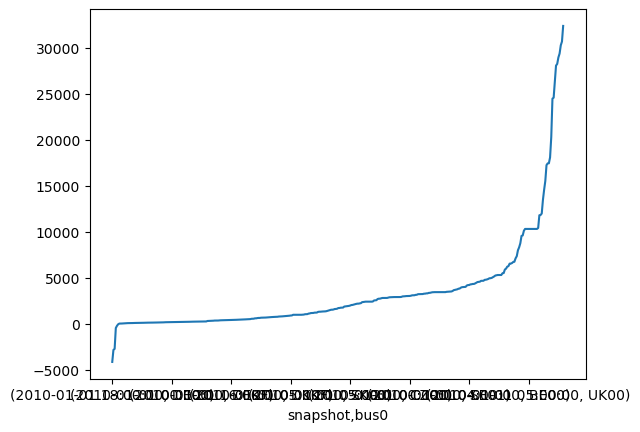

In [245]:
np[n.buses_t.active_local_matching[np.columns] >= 0.9].stack().sort_values().plot()

In [209]:
n.generators_t.p.groupby(n.generators.bus, axis=1).sum()

bus,AL00,AL00 reservoir,AT00,AT00 battery,AT00 reservoir,BA00,BA00 reservoir,BE00,BE00 PHS,BE00 battery,...,SI00 reservoir,SK00,SK00 PHS,SK00 battery,SK00 reservoir,UK00,UK00 PHS,UK00 battery,UKNI,UKNI battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,42.911750,1452.194213,2459.039795,0.0,285.469919,997.510753,301.035269,9629.912185,0.0,0.0,...,0.0,3595.119034,0.0,0.0,15.056519,46568.320488,0.0,0.0,425.410162,0.0
2010-01-01 01:00:00,41.465600,644.797742,2352.157476,0.0,285.469919,984.732716,301.035269,9970.542214,0.0,0.0,...,0.0,3587.214294,0.0,0.0,15.056519,38306.850205,0.0,0.0,400.195575,0.0
2010-01-01 02:00:00,40.027841,1443.168262,2242.273551,0.0,285.469919,977.787491,301.035269,10272.600903,0.0,0.0,...,0.0,3581.895548,0.0,0.0,15.056519,38229.671526,0.0,0.0,388.129202,0.0
2010-01-01 03:00:00,38.844670,1452.194213,2184.142624,0.0,285.469919,973.902164,301.035269,10592.001423,0.0,0.0,...,0.0,3579.059128,0.0,0.0,15.056519,38370.144328,0.0,0.0,403.523126,0.0
2010-01-01 04:00:00,37.363496,1452.194213,2149.737928,0.0,285.469919,968.442355,301.035269,10939.124972,0.0,0.0,...,0.0,3577.229194,0.0,0.0,15.056519,38637.603563,0.0,0.0,413.764685,0.0
2010-01-01 05:00:00,35.326539,1452.194213,2143.311436,0.0,285.469919,959.623155,301.035269,11179.562523,0.0,0.0,...,0.0,3482.174179,0.0,0.0,15.056519,40558.622619,0.0,0.0,439.551474,0.0
2010-01-01 06:00:00,33.403639,1452.194213,2160.308972,0.0,285.469919,948.636905,301.035269,11340.348051,0.0,0.0,...,0.0,3481.887621,0.0,0.0,15.056519,39616.860920,0.0,0.0,463.418161,0.0
2010-01-01 07:00:00,58.783111,1452.194213,2170.569678,0.0,285.469919,948.995638,301.035269,11439.819225,0.0,0.0,...,0.0,3481.968007,0.0,0.0,15.056519,41646.202982,0.0,0.0,484.630744,0.0
2010-01-01 08:00:00,92.778011,1452.194213,2775.333620,0.0,285.469919,960.882523,301.035269,11486.989943,0.0,0.0,...,0.0,3586.994819,0.0,0.0,15.056519,41871.564214,0.0,0.0,475.372224,0.0


In [71]:
solve_rolling_horizon(m, n, "h", storage_preopt_aggregation)

optimizing time period between 2010-01-01 00:00:00 and 2010-01-02 23:00:00


INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 58.38it/s]
INFO:linopy.io: Writing time: 4.05s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.14 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Simplex_PGradient                       3
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_SolutionType                            1
CPXPARAM_Barrier_Algorithm                       3
CPXPARAM_Barrier_Display                         2
CPXPARAM_Barrier_StartAlg                        2
CPXPARAM_Barrier_Crossover                       1
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     1.0000000000000001e-05
CPXPARAM_Barrier_Limits_ObjRange                 9.9999999999999993e+74
Tried aggregator 1 time.
LP Presolve eliminated 161308 rows and 29386 columns.
Aggregator did 5830 substitutions.
Reduced LP has 168915 rows, 96544 columns, and 1174695 nonzeros.
Presolve time = 

  27   8.8811780e+08   3.3158820e+08  8.69e+02  5.19e+02  8.56e-02
       0.15s (253.32 ticks) for iteration (0.10s, 15867 Mflops for lin. solve)
Refinement - orig 1.61e-02, refined 1.61e-02, target 1.74e+02, 0 iter
  28   8.3187031e+08   5.3011439e+08  3.62e+02  2.17e+02  6.38e-02
       0.14s (253.32 ticks) for iteration (0.09s, 16715 Mflops for lin. solve)
Refinement - orig 1.72e-02, refined 1.72e-02, target 7.25e+01, 0 iter
  29   8.0487142e+08   6.5125318e+08  1.74e+02  1.04e+02  5.34e-02
       0.15s (253.32 ticks) for iteration (0.10s, 15930 Mflops for lin. solve)
Refinement - orig 1.45e-02, refined 1.45e-02, target 3.47e+01, 0 iter
  30   7.8836383e+08   6.9971697e+08  7.63e+01  4.56e+01  3.61e-02
       0.17s (255.37 ticks) for iteration (0.11s, 13934 Mflops for lin. solve)
Refinement - orig 1.58e-02, refined 1.58e-02, target 1.53e+01, 0 iter
  31   7.8104242e+08   7.2294142e+08  4.18e+01  2.50e+01  2.61e-02
       0.16s (253.66 ticks) for iteration (0.10s, 15359 Mflops for li

    40030 DMoves:  Infeasibility  7.34856143e+01  Objective  7.66633967e+08
    38167 DMoves:  Infeasibility  7.34856148e+01  Objective  7.66633967e+08
    35529 DMoves:  Infeasibility  7.34856163e+01  Objective  7.66633967e+08
    33537 DMoves:  Infeasibility  7.34856143e+01  Objective  7.66633967e+08
    31908 DMoves:  Infeasibility  7.34856143e+01  Objective  7.66633967e+08
    29740 DMoves:  Infeasibility  7.34856143e+01  Objective  7.66633967e+08
    27277 DMoves:  Infeasibility  7.34855986e+01  Objective  7.66633967e+08
     8131 DMoves:  Infeasibility  7.23011296e+01  Objective  7.66633967e+08
     6260 DMoves:  Infeasibility  7.16911286e+01  Objective  7.66633967e+08
     4267 DMoves:  Infeasibility  7.16911285e+01  Objective  7.66633967e+08
     3097 DMoves:  Infeasibility  7.16911277e+01  Objective  7.66633967e+08
     1959 DMoves:  Infeasibility  7.13727009e+01  Objective  7.66634031e+08
        0 DMoves:  Infeasibility  2.25579522e+01  Objective  7.66634031e+08
  Dual:  Pus

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131280 primals, 336053 duals
Objective: 7.67e+08
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Bus-ORDC were not assigned to the network.


optimizing time period between 2010-01-03 00:00:00 and 2010-01-04 23:00:00


INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 58.75it/s]
INFO:linopy.io: Writing time: 4.1s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.15 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Simplex_PGradient                       3
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_SolutionType                            1
CPXPARAM_Barrier_Algorithm                       3
CPXPARAM_Barrier_Display                         2
CPXPARAM_Barrier_StartAlg                        2
CPXPARAM_Barrier_Crossover                       1
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     1.0000000000000001e-05
CPXPARAM_Barrier_Limits_ObjRange                 9.9999999999999993e+74
Tried aggregator 1 time.
LP Presolve eliminated 156122 rows and 27841 columns.
Aggregator did 5792 substitutions.
Reduced LP has 174224 rows, 98127 columns, and 1191210 nonzeros.
Presolve time = 

Refinement - orig 1.37e-02, refined 1.37e-02, target 1.07e+03, 0 iter
  27   8.2033755e+08  -9.0834498e+06  2.85e+03  1.65e+03  1.69e-01
       0.16s (256.60 ticks) for iteration (0.10s, 15310 Mflops for lin. solve)
Refinement - orig 1.01e-02, refined 1.01e-02, target 5.70e+02, 0 iter
  28   7.6385872e+08   1.8244889e+08  1.74e+03  1.01e+03  1.10e-01
       0.15s (256.60 ticks) for iteration (0.10s, 15691 Mflops for lin. solve)
Refinement - orig 7.82e-03, refined 7.82e-03, target 3.48e+02, 0 iter
  29   7.2238696e+08   3.0320591e+08  9.60e+02  5.57e+02  7.19e-02
       0.17s (256.60 ticks) for iteration (0.11s, 13684 Mflops for lin. solve)
Refinement - orig 1.35e-02, refined 1.35e-02, target 1.92e+02, 0 iter
  30   6.9506573e+08   4.5447860e+08  6.26e+02  3.63e+02  6.85e-02
       0.16s (258.35 ticks) for iteration (0.10s, 15654 Mflops for lin. solve)
Refinement - orig 9.66e-03, refined 9.66e-03, target 1.25e+02, 0 iter
  31   6.8131089e+08   4.8264026e+08  4.62e+02  2.68e+02  5.31e-02

     2821 PMoves:  Infeasibility  2.96791399e-03  Objective  6.19351700e+08
     1500 PMoves:  Infeasibility  1.29469537e-03  Objective  6.19351691e+08
      721 PMoves:  Infeasibility  8.08424510e-05  Objective  6.19351666e+08
        0 PMoves:  Infeasibility  7.86090490e-05  Objective  6.19351653e+08
  Primal:  Pushed 18642, exchanged 14303.
  Dual:  Fixing 126526 variables.
   126525 DMoves:  Infeasibility  7.65303270e+02  Objective  6.19361389e+08
   124263 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   123034 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   122171 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   119750 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   118154 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   116460 DMoves:  Infeasibility  7.65302970e+02  Objective  6.19361389e+08
   114774 DMoves:  Infeasibility  7.65302965e+02  Objective  6.19361389e+08
   113038 DM

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131280 primals, 336138 duals
Objective: 6.19e+08
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Bus-ORDC were not assigned to the network.


optimizing time period between 2010-01-05 00:00:00 and 2010-01-06 23:00:00


INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.38it/s]
INFO:linopy.io: Writing time: 4.56s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.16 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Simplex_PGradient                       3
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_SolutionType                            1
CPXPARAM_Barrier_Algorithm                       3
CPXPARAM_Barrier_Display                         2
CPXPARAM_Barrier_StartAlg                        2
CPXPARAM_Barrier_Crossover                       1
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     1.0000000000000001e-05
CPXPARAM_Barrier_Limits_ObjRange                 9.9999999999999993e+74
Tried aggregator 1 time.
LP Presolve eliminated 156263 rows and 27898 columns.
Aggregator did 5803 substitutions.
Reduced LP has 174181 rows, 98059 columns, and 1193740 nonzeros.
Presolve time = 

Refinement - orig 6.45e-03, refined 6.45e-03, target 1.97e+03, 0 iter
  27   8.3462235e+08   5.8367587e+07  3.88e+03  2.25e+03  2.82e-01
       0.18s (257.96 ticks) for iteration (0.12s, 12835 Mflops for lin. solve)
Refinement - orig 9.91e-03, refined 9.91e-03, target 7.75e+02, 0 iter
  28   7.6383380e+08   2.7195739e+08  1.91e+03  1.11e+03  1.35e-01
       0.14s (257.96 ticks) for iteration (0.09s, 17467 Mflops for lin. solve)
Refinement - orig 1.17e-02, refined 1.17e-02, target 3.81e+02, 0 iter
  29   7.3221621e+08   4.4500927e+08  1.23e+03  7.12e+02  7.32e-02
       0.15s (257.96 ticks) for iteration (0.10s, 16347 Mflops for lin. solve)
Refinement - orig 9.30e-03, refined 9.30e-03, target 2.46e+02, 0 iter
  30   7.0791427e+08   5.2072155e+08  7.70e+02  4.46e+02  4.94e-02
       0.16s (259.71 ticks) for iteration (0.10s, 15558 Mflops for lin. solve)
Refinement - orig 9.92e-03, refined 9.92e-03, target 1.54e+02, 0 iter
  31   6.7502458e+08   5.7038991e+08  2.11e+02  1.22e+02  3.45e-02

     5368 DMoves:  Infeasibility  1.67928549e+03  Objective  6.45334032e+08
        0 DMoves:  Infeasibility  1.18514471e+03  Objective  6.45322095e+08
  Dual:  Pushed 32450, exchanged 16747.

Iteration log . . .
Iteration:     1    Objective     =     645322094.784366
Iteration:     6    Objective     =     645321828.448153
Elapsed time = 18.84 sec. (22220.84 ticks, 6 iterations)
Removing shift (52).
Total crossover time = 7.17 sec. (5702.47 ticks)

Total time on 4 threads = 19.46 sec. (22582.71 ticks)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131280 primals, 336247 duals
Objective: 6.45e+08
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Bus-ORDC were not assigned to the network.


optimizing time period between 2010-01-07 00:00:00 and 2010-01-08 23:00:00


INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.48it/s]
INFO:linopy.io: Writing time: 4.24s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.17 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Simplex_PGradient                       3
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_SolutionType                            1
CPXPARAM_Barrier_Algorithm                       3
CPXPARAM_Barrier_Display                         2
CPXPARAM_Barrier_StartAlg                        2
CPXPARAM_Barrier_Crossover                       1
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     1.0000000000000001e-05
CPXPARAM_Barrier_Limits_ObjRange                 9.9999999999999993e+74
Tried aggregator 1 time.
LP Presolve eliminated 156552 rows and 27881 columns.
Aggregator did 5827 substitutions.
Reduced LP has 174213 rows, 98052 columns, and 1211771 nonzeros.
Presolve time = 

Refinement - orig 5.81e-03, refined 5.81e-03, target 1.80e+03, 0 iter
  27   9.8351092e+08  -2.3252984e+08  2.77e+03  1.61e+03  2.38e-01
       0.18s (268.03 ticks) for iteration (0.11s, 14396 Mflops for lin. solve)
Refinement - orig 1.36e-02, refined 1.36e-02, target 5.54e+02, 0 iter
  28   9.0264158e+08   1.5519475e+08  1.35e+03  7.82e+02  1.37e-01
       0.17s (268.03 ticks) for iteration (0.12s, 13977 Mflops for lin. solve)
Refinement - orig 1.52e-02, refined 1.52e-02, target 2.70e+02, 0 iter
  29   8.4842504e+08   4.8411611e+08  6.18e+02  3.59e+02  7.57e-02
       0.16s (268.03 ticks) for iteration (0.10s, 16800 Mflops for lin. solve)
Refinement - orig 1.74e-02, refined 1.74e-02, target 1.24e+02, 0 iter
  30   8.2433690e+08   5.5814856e+08  3.32e+02  1.93e+02  5.52e-02
       0.16s (269.78 ticks) for iteration (0.11s, 15072 Mflops for lin. solve)
Refinement - orig 2.50e-02, refined 2.50e-02, target 6.65e+01, 0 iter
  31   8.0162532e+08   6.1726860e+08  1.63e+02  9.47e+01  4.72e-02

    33398 DMoves:  Infeasibility  1.95342402e+03  Objective  7.69441528e+08
    31594 DMoves:  Infeasibility  1.95342402e+03  Objective  7.69441528e+08
    29739 DMoves:  Infeasibility  1.93804984e+03  Objective  7.69441528e+08
    26922 DMoves:  Infeasibility  1.93804984e+03  Objective  7.69441528e+08
    24671 DMoves:  Infeasibility  1.93804984e+03  Objective  7.69441528e+08
    22574 DMoves:  Infeasibility  1.93804984e+03  Objective  7.69441528e+08
     9779 DMoves:  Infeasibility  1.89767808e+03  Objective  7.69441528e+08
     7570 DMoves:  Infeasibility  1.84135994e+03  Objective  7.69441528e+08
     5726 DMoves:  Infeasibility  1.83027366e+03  Objective  7.69441528e+08
     3881 DMoves:  Infeasibility  1.67285196e+03  Objective  7.69430448e+08
     1916 DMoves:  Infeasibility  1.67223047e+03  Objective  7.69430448e+08
        0 DMoves:  Infeasibility  5.67440700e+02  Objective  7.69430447e+08
  Dual:  Pushed 26722, exchanged 17020.

Iteration log . . .
Iteration:     1    Objecti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131280 primals, 336592 duals
Objective: 7.69e+08
Solver model: available
Solver message: optimal

/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/linopy/common.py:124: UserWarning: Coordinates across variables not equal. Perform outer join.
  warn("Coordinates across variables not equal. Perform outer join.", UserWarning)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Bus-ORDC were not assigned to the network.


optimizing time period between 2010-01-09 00:00:00 and 2010-01-10 23:00:00


INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.model:Solver options:
 - threads: 4
 - lpmethod: 4
 - solutiontype: 1
 - barrier.convergetol: 1e-05
 - feasopt.tolerance: 1e-05
 - barrier.limits.objrange: 1e+75
 - barrier.crossover: 1
 - barrier.display: 2
 - barrier.algorithm: 3
 - barrier.startalg: 2
 - preprocessing.dual: -1
 - simplex.pgradient: 3
INFO:linopy.io:Writing objective.
Writing constraints.:  97%|████████████████████████████████████████████████████████████████████████████████▎  | 30/31 [00:03<00:00,  9.76it/s]


KeyboardInterrupt: 

In [52]:
dirname = os.path.dirname(solved_network)

In [53]:
if not os.path.isdir(dirname):
    os.makedirs(dirname)

In [54]:
n = pypsa.Network(solved_network)

       'AL00-ME00-AC', 'AL00-MK00-AC', 'AL00-RS00-AC', 'AT00 battery charger',
       'AT00 battery discharger', 'AT00 reservoir charger',
       'AT00 reservoir discharger',
       ...
       'UK00-DKW1-DC', 'UK00-FR00-DC', 'UK00-IE00-DC', 'UK00-NL00-DC',
       'UK00-NOS0-DC', 'UK00-UKNI-DC', 'UKNI battery charger',
       'UKNI battery discharger', 'UKNI-IE00-AC', 'UKNI-UK00-DC'],
      dtype='object', name='Bus', length=361) for attribute mu_alegro of Bus are not in main components dataframe buses
       'DKE1-DE00', 'DKW1-DE00', 'DKW1-NL00', 'ES00-FR00', 'ITN1-AT00',
       'ITN1-FR00', 'ITN1-SI00', 'LT00-PL00', 'NOS0-DE00', 'NOS0-NL00',
       'RS00-HR00', 'RS00-HU00', 'RS00-RO00', 'SE04-DE00', 'SE04-PL00',
       'UK00-BE00', 'UK00-FR00', 'UK00-NL00'],
      dtype='object', name='Link') for attribute external_flow of Link are not in main components dataframe links
       'BA00 reservoir store', 'BE00 PHS store', 'BE00 battery store',
       'BG00 PHS store', 'BG00 reservoir stor

In [78]:
c = n.copy()

In [79]:
load_shedding = c.generators.filter(like="load-shedding", axis=0)

In [80]:
snapshots_with_curtailment = c.snapshots[c.generators_t.p[load_shedding.index].sum(axis=1)>0]

In [81]:
c.set_snapshots(snapshots_with_curtailment)

In [82]:
other_generators = c.generators.loc[c.generators.index.symmetric_difference(load_shedding.index)]

In [83]:
market_buses = c.buses.query("carrier == 'electricity'").index

In [84]:
generation = c.generators_t.p[other_generators.index].groupby(other_generators.bus, axis=1).sum()[market_buses]

In [85]:
itc_carriers  = ["AC", "DC"]

In [86]:
storage_links = c.links.query("carrier not in @itc_carriers")

In [87]:
net_positions = c.loads_t.p_set.groupby(c.loads.bus, axis=1).sum().subtract(
    c.generators_t.p[other_generators.index].groupby(other_generators.bus, axis=1).sum(),
    fill_value=0
).add(
    c.links_t.p0[storage_links.index].groupby(storage_links.bus0, axis=1).sum(),
    fill_value=0
).add(
    c.links_t.p1.groupby(storage_links.bus1, axis=1).sum(),
    fill_value=0
)[market_buses]

In [88]:
loads = c.loads_t.p_set.copy()

In [89]:
c.mremove("Generator", other_generators.index)
c.mremove("Load", c.loads.index)
c.mremove("Link", storage_links.index)
c.mremove("Store", c.stores.index)
c.mremove("Bus", c.buses.query("carrier != 'electricity'").index)
c.madd("Load", net_positions.columns, bus = net_positions.columns, p_set = net_positions)

Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF', 'DKE1', 'DKKF', 'DKW1', 'EE00', 'ES00', 'FI00', 'FR00', 'GR00',
       'GR03', 'HR00', 'HU00', 'IE00', 'ITCA', 'ITCN', 'ITCS', 'ITN1', 'ITS1',
       'ITSA', 'ITSI', 'LT00', 'LUG1', 'LV00', 'ME00', 'MK00', 'MT00', 'NL00',
       'NOM1', 'NON1', 'NOS0', 'PL00', 'PLE0', 'PLI0', 'PT00', 'RO00', 'RS00',
       'SE01', 'SE02', 'SE03', 'SE04', 'SI00', 'SK00', 'UK00', 'UKNI'],
      dtype='object')

In [105]:
loads.columns.name = "bus"

loads = loads.reindex(c.buses.index, axis=1, fill_value=1e-6)

In [90]:
for ls in load_shedding.index:
    c.generators_t.p_max_pu[ls] = 1

In [91]:
snapshots = c.snapshots

In [106]:
def curtailment_sharing(c, snapshots):

    m = c.model

    max_curtailment_ratio = m.add_variables(lower=0, coords=[snapshots] , name="Bus-max_curtailment_ratio")

    m.add_constraints(
        max_curtailment_ratio >= m["Generator-p"].groupby(c.generators.bus).sum()/loads.stack().to_xarray(),
        name="Bus-max_curtailment_ratio_constraint"
    )

    m.add_objective(
        max_curtailment_ratio.sum(),
        overwrite=True
    )

In [109]:
def cs_extra_functionality(n, snapshots):
    curtailment_sharing(n, snapshots)
    flow_based_market_coupling(n, snapshots)

In [110]:
c.optimize(solver_name="cplex", extra_functionality=cs_extra_functionality)

INFO:linopy.model: Solve problem using Cplex solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 128.31it/s]
INFO:linopy.io: Writing time: 2.13s


Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.03 s]
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 37958 rows and 8122 columns.
Aggregator did 2245 substitutions.
Reduced LP has 29900 rows, 9643 columns, and 806341 nonzeros.
Presolve time = 0.79 sec. (412.16 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.174012
Perturbation started.
Iteration:   101   Dual objective     =             2.174012
Iteration:   519   Dual objective     =             3.020008
Iteration:  1319   Dual objective     =             3.794823
Iteration:  2106   Dual objective     =             4.179083
Iteration:  2822   Dual objective     =             4.400568
Removing p

Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



('warning', 'infeasible')

In [30]:
load_shed = n.generators.filter(like = "load-shedding", axis=0)

(n.generators_t.p[load_shed.index]>0).sum().to_frame().to_csv(lole)

In [ ]:
def market_revenue(n):
    
    spot_prices = n.buses_t.marginal_price.reindex(n.generators.bus.values, axis=1)

    spot_prices.columns = n.generators.index

    spot_payments = spot_prices.subtract(
        n.generators.marginal_cost
    ).multiply(n.generators_t.p).sum()

    reserve_prices = n.buses_t.mu_reserve_balance.reindex(n.generators.bus.values, axis=1)

    reserve_prices.columns = n.generators.index

    reserve_payments = reserve_prices.multiply(n.generators_t.r).sum()

    return (spot_payments + reserve_payments)

In [ ]:
if not os.path.exists(os.path.dirname(revenues)):
    os.makedirs(os.path.dirname(revenues))

In [ ]:
if not os.path.exists(os.path.dirname(lole)):
    os.makedirs(os.path.dirname(lole))

In [ ]:
market_revenue(n).to_hdf(revenues, "revenues")

In [ ]:
(reserve_payments + spot_payments).div(n.generators.p_nom).sum()

In [ ]:
n.generators_t.p["AL00 CCGT"].iloc[:15*24].plot()

n.buses_t.marginal_price["AL00"].iloc[:15*24].plot()

In [ ]:
gradient_ramps = n.generators_t.status.multiply(
    n.generators.ramp_limit_up.subtract(
        n.generators.ramp_limit_start_up)
).subtract(
    n.generators_t.status.shift(1).multiply(
        n.generators.ramp_limit_start_up
    )
).multiply(n.generators_t.mu_ramp_limit_up).sum()

In [ ]:
(gradient_ramps + n.generators_t.mu_upper.sum())

In [ ]:
gradient_upper = 

In [ ]:
n.generators_t.mu_upper.sum().sum()/1e6

In [ ]:
n.generators_t.mu_up.sum()

In [ ]:
spot_prices = n.buses_t.marginal_price.reindex(n.generators.bus.values, axis=1)

In [ ]:
spot_prices.columns = n.generators.index

In [ ]:
spot_payments = spot_prices.subtract(
    n.generators.marginal_cost
).multiply(n.generators_t.p).sum()

In [ ]:
reserve_prices = n.buses_t.mu_reserve_balance.reindex(n.generators.bus.values, axis=1)

In [ ]:
reserve_prices.columns = n.generators.index

In [ ]:
reserve_payments = reserve_prices.multiply(n.generators_t.r).sum()

In [ ]:
(reserve_payments + spot_payments).div(n.generators.p_nom).sum()

In [ ]:
n_copy = n.copy()

In [ ]:
snapshots = n.snapshots[:24]

In [ ]:
n_copy.set_snapshots(snapshots)

In [ ]:
n_copy.generators.ramp_limit_up = 0.4
n_copy.generators.ramp_limit_down = 0.5
n_copy.generators.ramp_limit_start_up = 0.6
n_copy.generators.ramp_limit_start_down = 0.7


In [ ]:
n_copy.optimize(
    solver_name="highs", 
    linearized_unit_commitment=True,
    extra_functionality=extra_functionality,
    assign_all_duals=True
)

In [ ]:
n_copy.model

In [ ]:
m = n_copy.model

In [ ]:
constraint_list = [i for i in m.constraints if "Generator-com" in i]

In [ ]:
constraint_list[0]

In [ ]:
n_copy.generators.p_nom.multiply(n_copy.generators.p_min_pu)

In [ ]:
n.generators_t.mu_lower.sum()

In [ ]:
25.62/89.04

In [ ]:
n.generators.columns

In [ ]:
m.constraints[constraint_list[13]]

In [ ]:
n.generators_t.mu_up.sum()

In [ ]:
n.generators_t.mu_before.multiply(as_dense(n, "Generator", "p_max_pu")).sum()

In [ ]:
n.generators_t.mu_current.multiply(as_dense(n, "Generator", "p_max_pu")).sum()

In [ ]:
m.constraints["Generator-com-p-before"].lhs.loc[n_copy.snapshots[2], :]

In [ ]:
m.constraints["Generator-com-p-current"]